Cross-Validation Accuracy Scores: [1.         1.         1.         0.99770642 1.        ]
Average Cross-Validation Accuracy: 0.9995412844036696
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       479
           1       1.00      1.00      1.00       456

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935

Confusion Matrix:
 [[479   0]
 [  0 456]]


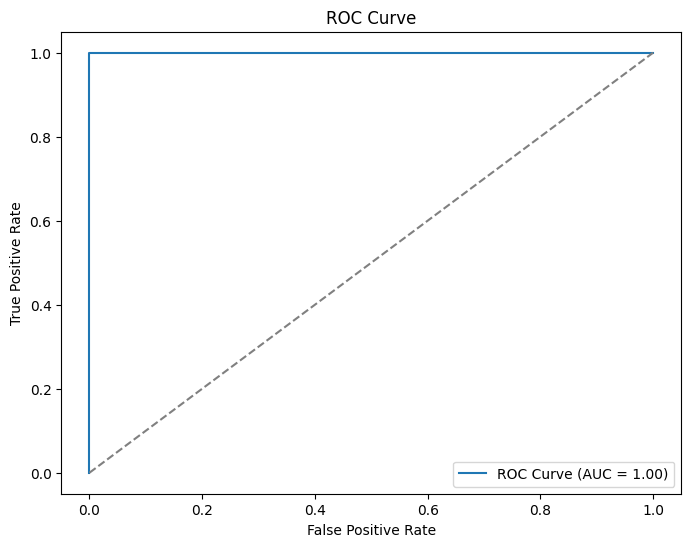

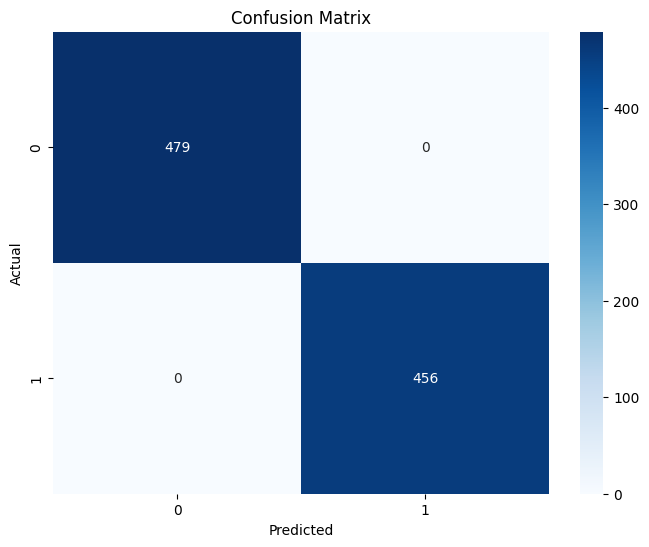

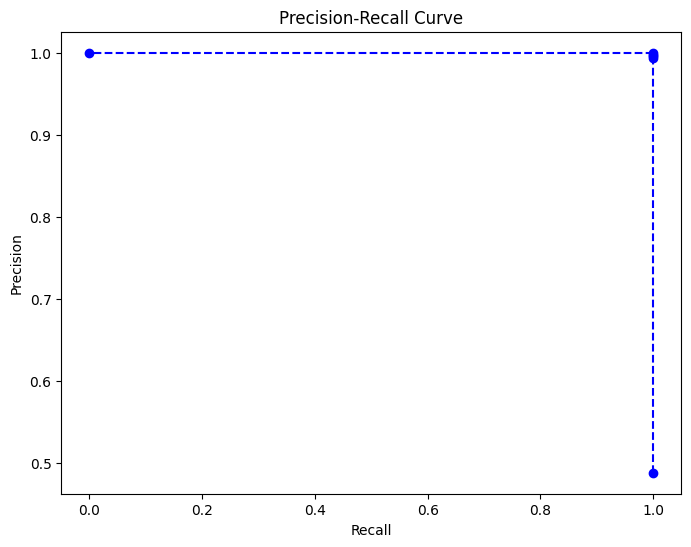

<ipython-input-5-036c7f1534bb>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


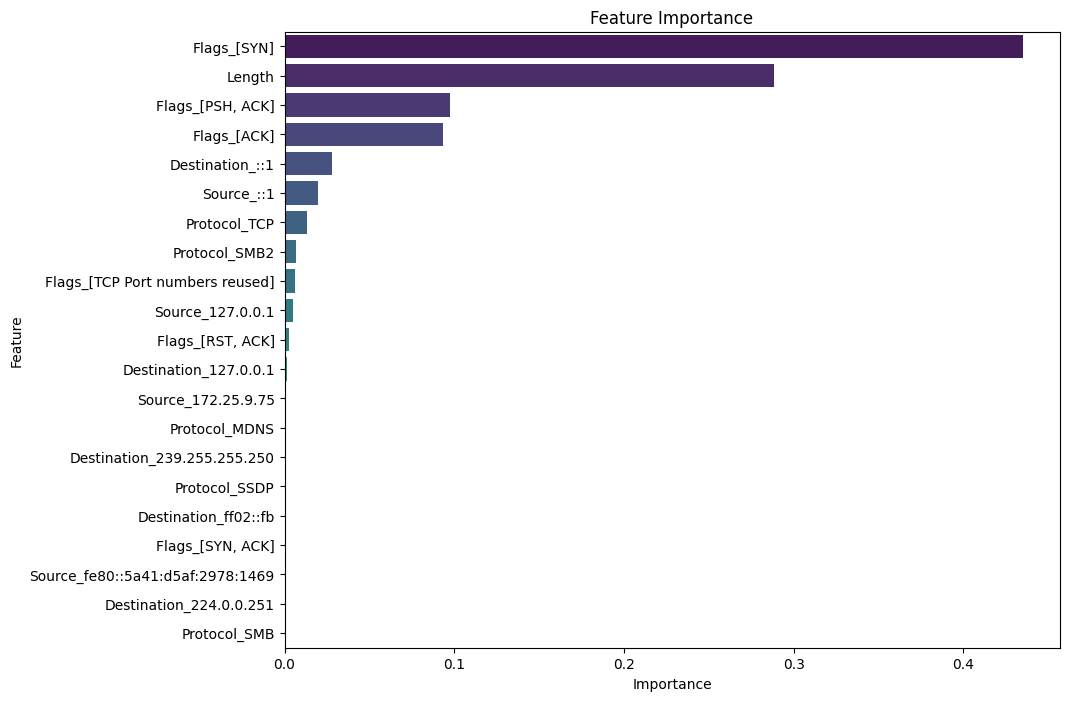

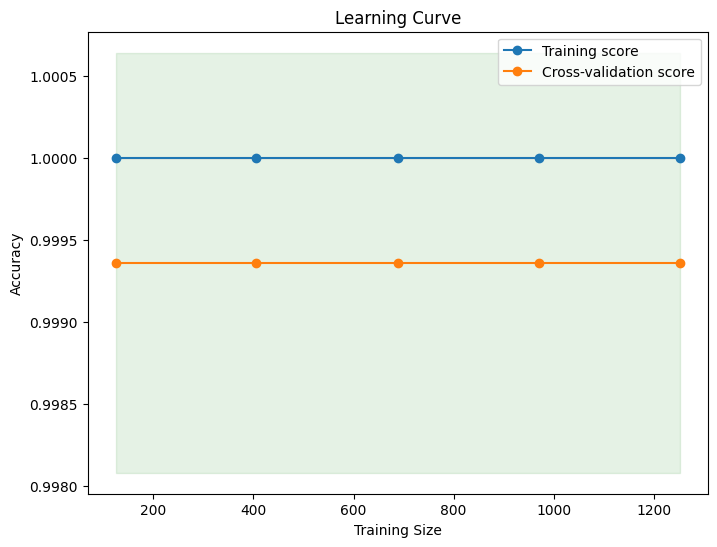

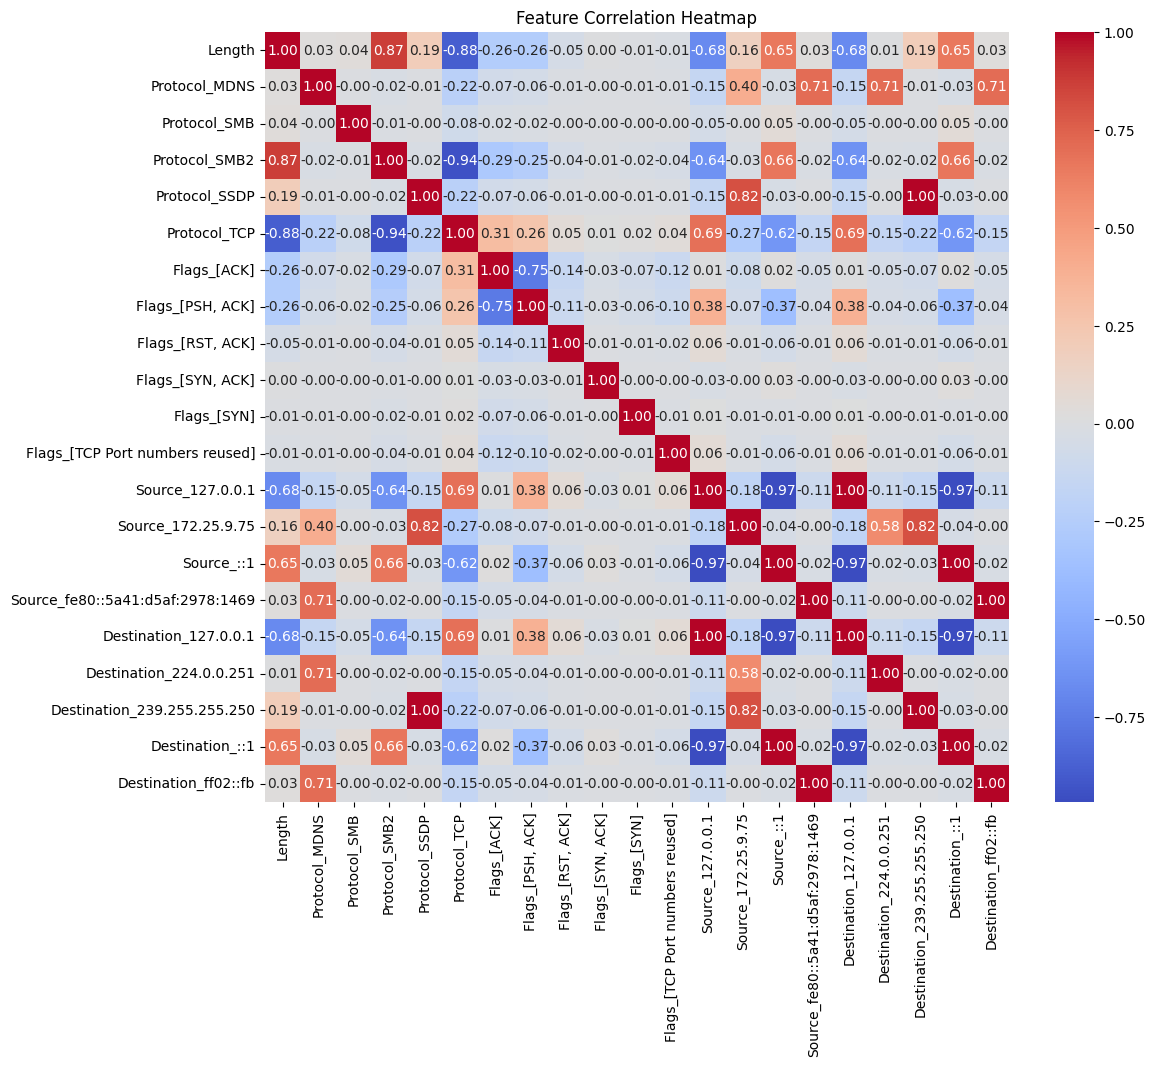

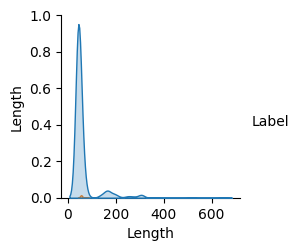

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load datasets (upload your CSV files to Colab first)
mqtt_df = pd.read_csv('mqtt_simulation.csv')
mqtt_plus_df = pd.read_csv('mqtt_plus.csv')

# Data Cleaning: Select relevant columns
mqtt_df = mqtt_df[['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']].copy()
mqtt_plus_df = mqtt_plus_df[['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']].copy()

# Feature Engineering: Extract TCP flags from 'Info' column
mqtt_df['Flags'] = mqtt_df['Info'].str.extract(r'(\[.*?\])')
mqtt_plus_df['Flags'] = mqtt_plus_df['Info'].str.extract(r'(\[.*?\])')

# Data Labeling: Basic heuristic (based on flags and packet length)
def label_traffic(row):
    if isinstance(row['Flags'], str) and ('[SYN]' in row['Flags'] or '[RST]' in row['Flags']):
        return 1  # Attack
    elif row['Length'] > 1000:
        return 1  # Attack
    return 0  # Normal

mqtt_df['Label'] = mqtt_df.apply(label_traffic, axis=1)
mqtt_plus_df['Label'] = mqtt_plus_df.apply(label_traffic, axis=1)

# Combine the datasets for training
combined_df = pd.concat([mqtt_df, mqtt_plus_df])

# Encode categorical features
combined_df = pd.get_dummies(combined_df, columns=['Protocol', 'Flags', 'Source', 'Destination'])

# Prepare features (X) and labels (y)
X = combined_df.drop(['Time', 'Info', 'Label'], axis=1)
y = combined_df['Label']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# Model Selection: Random Forest Classifier with Cross-Validation
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {cv_scores.mean()}')

# Fit the model
model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification Report and Confusion Matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC Score and Curve
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', linestyle='--', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Feature Importance
importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, marker='o', label='Training score')
plt.plot(train_sizes, test_mean, marker='o', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Feature Correlation Heatmap
corr = combined_df.drop(['Time', 'Info', 'Label'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Pairplot (if you have a smaller number of features)
sns.pairplot(combined_df[['Length', 'Info', 'Label']], hue='Label')
plt.show()
